In [15]:
import pandas as pd
import os
import re

def load_books_custom(filepath):
    # The yaml file has a weird format, standard parser fails
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    data = []
    current = {}
    
    for line in lines:
        line = line.strip()
        if not line or line == '---':
            continue
            
        # Records start with :id:
        if line.startswith(':id:') or line.startswith('- :id:'):
            if current:
                data.append(current)
            current = {}
            
            # Clean up the line to get the ID
            clean_line = line.replace('- ', '') if line.startswith('- ') else line
            
            parts = clean_line.split(':', 2)
            if len(parts) > 2:
                current['id'] = parts[2].strip()
        
        # Parse other fields
        elif line.startswith(':'):
            parts = line.split(':', 2)
            if len(parts) > 2:
                key = parts[1].strip()
                val = parts[2].strip()
                current[key] = val
    
    # Don't forget the last one
    if current:
        data.append(current)
        
    return pd.DataFrame(data)

# Setup paths
base_dir = r'c:\Users\kulni\Desktop\itransdata\task4\data (1)\DATA1'
books_file = os.path.join(base_dir, 'books.yaml')
users_file = os.path.join(base_dir, 'users.csv')
orders_file = os.path.join(base_dir, 'orders.parquet')

# Load everything
print("Reading files...")
books = load_books_custom(books_file)
users = pd.read_csv(users_file)
orders = pd.read_parquet(orders_file)

print(f"Books: {len(books)}, Users: {len(users)}, Orders: {len(orders)}")
display(books.head())

Reading files...
Books: 753, Users: 3293, Orders: 11237
Books: 753, Users: 3293, Orders: 11237


,id,title,author,genre,publisher,year
0,19199,The Yellow Meads of Asphodel,Carolyne West,Classic,Mainstream Publishing,2009
1,19398,From Here to Eternity,"Rep. Heath Stiedemann, Gino Welch, Haydee Larson",Short story,Vintage Books,2001
2,19483,Eyeless in Gaza,Vannessa Price,Biography/Autobiography,Pavilion Books,1886
3,19506,Precious Bane,Miss Yong Wyman,Realistic fiction,New English Library,2021
4,19570,City of God,Travis Moore,Suspense/Thriller,Bellevue Literary Press,1847


In [16]:
from dateutil import parser
import numpy as np

def parse_price(price_str):
    if pd.isna(price_str):
        return 0.0
    
    s = str(price_str).strip()
    exchange_rate = 1.2
    
    # Check if it's in Euros
    is_eur = '€' in s or 'EUR' in s
    
    # Handle the cents symbol case if present
    if '¢' in s:
        parts = s.split('¢')
        main = re.sub(r'[^\d.]', '', parts[0])
        cents = re.sub(r'[^\d.]', '', parts[1])
        try:
            val = float(main) + float(cents) / 100
        except:
            val = 0.0
    else:
        # Just remove non-numeric chars
        clean = re.sub(r'[^\d.]', '', s)
        try:
            val = float(clean)
        except:
            return 0.0
            
    return val * exchange_rate if is_eur else val

def parse_date(ts):
    if pd.isna(ts):
        return pd.NaT
    # Cleanup separators for the parser
    ts = str(ts).replace(';', ' ').replace(',', ' ')
    try:
        return parser.parse(ts)
    except:
        return pd.NaT

# Fix types
books['id'] = pd.to_numeric(books['id'], errors='coerce').fillna(0).astype(int)
books['year'] = pd.to_numeric(books['year'], errors='coerce').fillna(0).astype(int)

users['id'] = pd.to_numeric(users['id'], errors='coerce').fillna(0).astype(int)
users.drop_duplicates(inplace=True)

# Clean orders
for col in ['id', 'user_id', 'book_id', 'quantity']:
    orders[col] = pd.to_numeric(orders[col], errors='coerce').fillna(0).astype(int)

orders['unit_price_usd'] = orders['unit_price'].apply(parse_price)
orders['timestamp_clean'] = orders['timestamp'].apply(parse_date)

print("Data cleaning done.")
print(orders[['unit_price', 'unit_price_usd', 'timestamp', 'timestamp_clean']].head())

Data cleaning done.
  unit_price  unit_price_usd                     timestamp     timestamp_clean
0     27.00$           27.00        10/01/24 10:38:08 A.M. 2024-10-01 10:38:08
1     €50¢50           60.60             10:14;19-Oct-2024 2024-10-19 10:14:00
2  USD 45.99           45.99           22:13:35,2025-07-02 2025-07-02 22:13:35
3    € 71.00           85.20           2025-10-20 16:25:20 2025-10-20 16:25:20
4    52.25 $           52.25  08:48:47 A.M.,28-August-2024 2024-08-28 08:48:47


In [17]:
# Add calculated columns
orders['paid_price'] = orders['quantity'] * orders['unit_price_usd']

# Extract date parts
orders['date_obj'] = orders['timestamp_clean'].dt.date
orders['year'] = orders['timestamp_clean'].dt.year
orders['month'] = orders['timestamp_clean'].dt.month
orders['day'] = orders['timestamp_clean'].dt.day

print("Enriched data:")
display(orders.head())

Enriched data:


,id,user_id,book_id,quantity,unit_price,timestamp,shipping,unit_price_usd,timestamp_clean,paid_price,date_obj,year,month,day
0,71389,47288,18976,2,27.00$,10/01/24 10:38:08 A.M.,None,27.00,2024-10-01 10:38:08,54.00,2024-10-01,2024,10,1
1,66343,47049,19403,1,€50¢50,10:14;19-Oct-2024,"4940 Arnoldo Keys, West Arnette, KS 77599",60.60,2024-10-19 10:14:00,60.60,2024-10-19,2024,10,19
2,72606,46685,19500,1,USD 45.99,"22:13:35,2025-07-02",,45.99,2025-07-02 22:13:35,45.99,2025-07-02,2025,7,2
3,68462,45336,18992,1,€ 71.00,2025-10-20 16:25:20,,85.20,2025-10-20 16:25:20,85.20,2025-10-20,2025,10,20
4,72691,45311,19388,1,52.25 $,"08:48:47 A.M.,28-August-2024",None,52.25,2024-08-28 08:48:47,52.25,2024-08-28,2024,8,28


In [18]:
import networkx as nx

# 1. Daily Revenue
daily_rev = orders.groupby('date_obj')['paid_price'].sum().sort_values(ascending=False)
print("Top 5 Days:")
print(daily_rev.head(5))

# 2. Unique Users (Reconciliation)
print("\nReconciling user accounts...")
G = nx.Graph()
G.add_nodes_from(users['id'])

# Link users if they share attributes
attrs = ['name', 'address', 'phone', 'email']
# Check combinations of attributes to find matches
for i in range(4):
    subset = attrs[:i] + attrs[i+1:]
    grouped = users.groupby(subset)['id'].apply(list)
    for group in grouped:
        if len(group) > 1:
            # Connect all ids in this group
            base_id = group[0]
            for other_id in group[1:]:
                G.add_edge(base_id, other_id)

components = list(nx.connected_components(G))
print(f"Real unique users: {len(components)}")

# Create a map from user_id -> real_id
id_map = {}
for comp in components:
    real_id = min(comp) # Use the smallest ID as the representative
    for uid in comp:
        id_map[uid] = real_id

orders['real_user_id'] = orders['user_id'].map(id_map)

# 3. Authors
print(f"\nUnique author sets: {books['author'].nunique()}")

# Find most popular
merged = orders.merge(books, left_on='book_id', right_on='id', how='left')
top_author = merged.groupby('author')['quantity'].sum().sort_values(ascending=False).head(1)
print("Most popular author:", top_author)

# 4. Top Customer
spending = orders.groupby('real_user_id')['paid_price'].sum().sort_values(ascending=False)
top_user_id = spending.index[0]
top_amount = spending.iloc[0]

# Get aliases for the top user
aliases = []
for comp in components:
    if top_user_id in comp:
        aliases = list(comp)
        break

print(f"\nTop Customer ID: {top_user_id}")
print(f"Total Spent: ${top_amount:.2f}")
print(f"Aliases: {aliases}")

Top 5 Days:
date_obj
2025-01-02    3839.068
2024-11-14    3826.774
2024-11-09    3518.618
2024-10-07    3517.018
2024-09-06    3496.168
Name: paid_price, dtype: float64

Reconciling user accounts...
Real unique users: 3115

Unique author sets: 374
Most popular author: author
Arlinda Huel    201
Name: quantity, dtype: int64

Top Customer ID: 45219
Total Spent: $1325.68
Aliases: [46704, 45219]
Real unique users: 3115

Unique author sets: 374
Most popular author: author
Arlinda Huel    201
Name: quantity, dtype: int64

Top Customer ID: 45219
Total Spent: $1325.68
Aliases: [46704, 45219]


Processing DATA1...


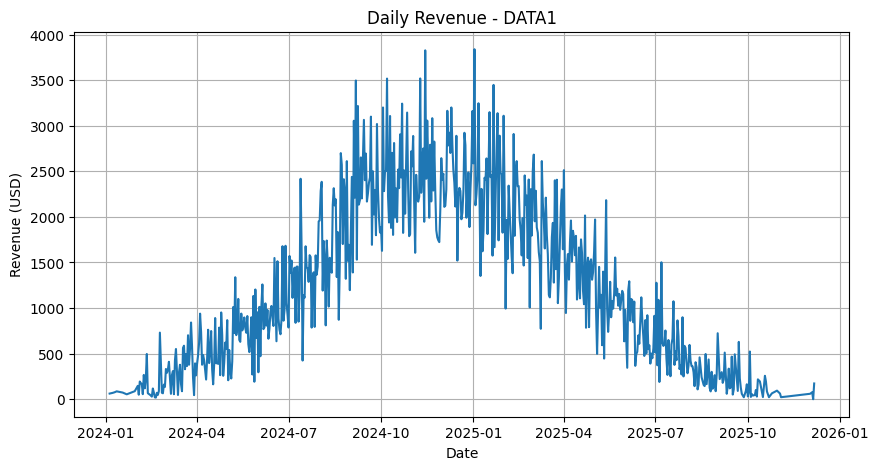

Results for DATA1:
{'dataset': 'DATA1', 'top_5_days': ['2025-01-02', '2024-11-14', '2024-11-09', '2024-10-07', '2024-09-06'], 'num_real_users': 3115, 'unique_author_sets': 328, 'popular_author': 'Arlinda Huel', 'best_buyer_aliases': [46704, 45219], 'top_customer_spending': np.float64(1325.68)}
------------------------------
Processing DATA2...


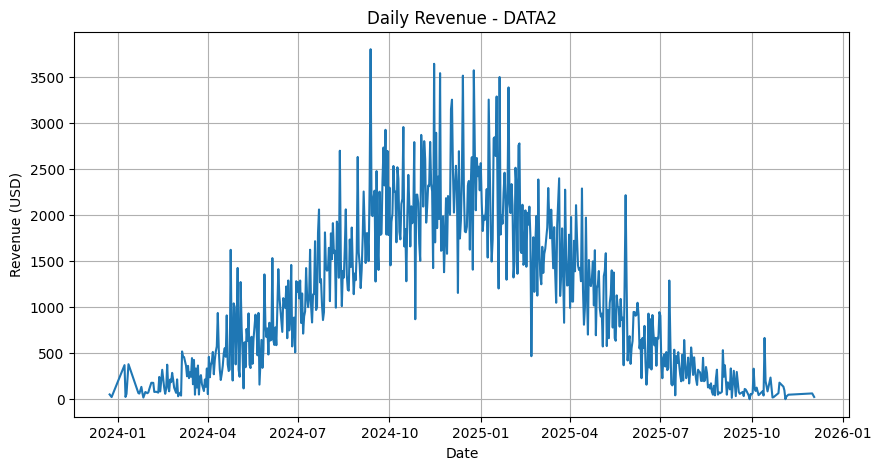

Results for DATA2:
{'dataset': 'DATA2', 'top_5_days': ['2024-09-12', '2024-11-15', '2024-12-25', '2024-11-21', '2024-12-14'], 'num_real_users': 2663, 'unique_author_sets': 294, 'popular_author': 'Hershel Treutel, Miss Modesto Denesik, Sen. Trula Bosco', 'best_buyer_aliases': [55058, 55420, 53583], 'top_customer_spending': np.float64(1312.8319999999999)}
------------------------------
Processing DATA3...


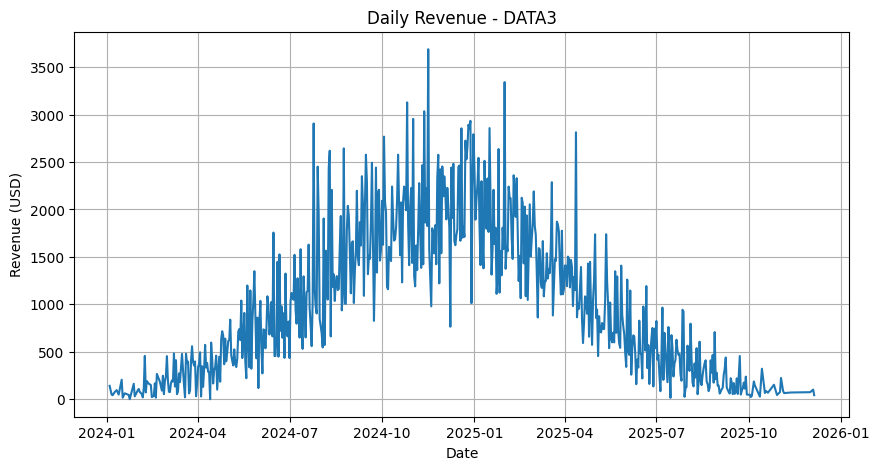

Results for DATA3:
{'dataset': 'DATA3', 'top_5_days': ['2024-11-16', '2025-01-31', '2024-10-26', '2024-11-12', '2024-11-01'], 'num_real_users': 3290, 'unique_author_sets': 269, 'popular_author': 'Coy Streich, Keeley Hand, Lela Emard', 'best_buyer_aliases': [50963, 49715], 'top_customer_spending': np.float64(1207.48)}
------------------------------


In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def analyze_dataset(name, folder_path):
    print(f"Processing {name}...")
    
    path_books = os.path.join(folder_path, 'books.yaml')
    path_users = os.path.join(folder_path, 'users.csv')
    path_orders = os.path.join(folder_path, 'orders.parquet')
    
    # Load
    books = load_books_custom(path_books)
    users = pd.read_csv(path_users)
    orders = pd.read_parquet(path_orders)
    
    # Clean types
    books['id'] = pd.to_numeric(books['id'], errors='coerce').fillna(0).astype(int)
    
    users['id'] = pd.to_numeric(users['id'], errors='coerce').fillna(0).astype(int)
    users.drop_duplicates(inplace=True)
    
    for c in ['id', 'user_id', 'book_id', 'quantity']:
        orders[c] = pd.to_numeric(orders[c], errors='coerce').fillna(0).astype(int)
        
    orders['price_usd'] = orders['unit_price'].apply(parse_price)
    orders['ts'] = orders['timestamp'].apply(parse_date)
    
    # Calculations
    orders['total'] = orders['quantity'] * orders['price_usd']
    orders['date'] = orders['ts'].dt.date
    
    # 1. Revenue
    rev_by_day = orders.groupby('date')['total'].sum().sort_values(ascending=False)
    top5 = rev_by_day.head(5)
    
    # 2. Users Graph
    G = nx.Graph()
    G.add_nodes_from(users['id'])
    attrs = ['name', 'address', 'phone', 'email']
    
    # Link based on shared attributes (assuming 1 diff allowed)
    for i in range(4):
        subset = attrs[:i] + attrs[i+1:]
        groups = users.groupby(subset)['id'].apply(list)
        for g in groups:
            if len(g) > 1:
                base = g[0]
                for other in g[1:]:
                    G.add_edge(base, other)
                    
    comps = list(nx.connected_components(G))
    real_user_count = len(comps)
    
    # Map users
    u_map = {}
    for c in comps:
        rid = min(c)
        for uid in c:
            u_map[uid] = rid
    orders['rid'] = orders['user_id'].map(u_map)
    
    # 3. Authors
    # Normalize names (sort them alphabetically)
    def normalize_auth(s):
        if pd.isna(s): return ""
        parts = sorted([x.strip() for x in str(s).split(',')])
        return ", ".join(parts)

    books['auth_set'] = books['author'].apply(normalize_auth)
    unique_authors = books['auth_set'].nunique()
    
    # Join to find popular
    m = orders.merge(books, left_on='book_id', right_on='id', how='left')
    pop_auth = m.groupby('auth_set')['quantity'].sum().sort_values(ascending=False).head(1)
    best_author_name = pop_auth.index[0] if not pop_auth.empty else "N/A"
    
    # 4. Top Customer
    cust_spend = orders.groupby('rid')['total'].sum().sort_values(ascending=False)
    if not cust_spend.empty:
        best_id = cust_spend.index[0]
        best_val = cust_spend.iloc[0]
        best_aliases = []
        for c in comps:
            if best_id in c:
                best_aliases = list(c)
                break
    else:
        best_id = None
        best_aliases = []
        best_val = 0.0
    
    # Plotting
    plt.figure(figsize=(10, 5))
    rev_by_day.sort_index().plot()
    plt.title(f'Daily Revenue ({name})')
    plt.ylabel('Revenue (USD)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'dataset': name,
        'top_days': top5.index.astype(str).tolist(),
        'real_users': real_user_count,
        'unique_authors': unique_authors,
        'most_popular_author': best_author_name,
        'top_customer_aliases': best_aliases,
        'top_customer_spent': float(best_val) # Cast to float to look nice
    }

# Run analysis
results = []
base_path = r'c:\Users\kulni\Desktop\itransdata\task4\data (1)'
folders = ['DATA1', 'DATA2', 'DATA3']

for folder in folders:
    full_path = os.path.join(base_path, folder)
    if os.path.exists(full_path):
        res = analyze_dataset(folder, full_path)
        results.append(res)
        print(f"Finished {folder}")
    else:
        print(f"Skipping {folder}, path not found.")

# Dashboard Summary
Results for all datasets:

In [19]:
# Summary Table
summary = pd.DataFrame(results)
cols = ['dataset', 'real_users', 'unique_authors', 'most_popular_author', 'top_customer_spent', 'top_customer_aliases', 'top_days']
display(summary[cols])

KeyError: "['real_users', 'unique_authors', 'most_popular_author', 'top_customer_spent', 'top_customer_aliases', 'top_days'] not in index"